# MIDI to RNN Input data treatment

This script was implemented to transform the pre-treated midi data to value arrays that can be served as input for the RNN training.

In [1]:
import pretty_midi
import numpy as np
import pandas as pd
import glob
import json

## MIDI data attributes analysis

In [2]:
midi_files = glob.glob(r"..\midi\treated_midi\*")
midi_file = pretty_midi.PrettyMIDI(midi_files[0])

instrument = midi_file.instruments[0]
print(pretty_midi.program_to_instrument_name(instrument.program))

note = instrument.notes[0]
print(note)

Acoustic Grand Piano
Note(start=0.000000, end=0.136364, pitch=76, velocity=60)


Looking at the previous snippet, the Note class has four attributes:
* **start**: time when the note starts (in seconds)
* **end**: time when the note ends (in seconds)
* **pitch**: pitch of the note (can be associated with the piano key)
* **velocity**: information on the volume of the note - during pre-treatment all notes were set with velocity of 60.

We can disconsider the velocity information, as it has no relevant information for the structure of the song.

Firstly, the data can be moved to an dictionary of dataframes, in which every single dataframe corresponds to a song.

In [3]:
data_dict = {}
for midi_file in midi_files:
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    song_dict = {
        "start": [],
        "end": [],
        "pitch": [],
    }
    for note in midi_data.instruments[0].notes:
        song_dict["start"].append(note.start)
        song_dict["end"].append(note.end)
        song_dict["pitch"].append(note.pitch)
    data_dict[midi_file.split("\\")[-1].split(".")[0]] = pd.DataFrame(song_dict).sort_values(by=['start', 'end'])

dict_key = list(data_dict.keys())[0]
print(f'{dict_key}\n{"-"*40}\n{data_dict[dict_key]}')

160_EIGHTMEASURE_EXERCISES_NO_1
----------------------------------------
         start        end  pitch
0     0.000000   0.136364     76
3     0.000000   0.545455     60
4     0.000000   0.545455     67
1     0.136364   0.272727     79
2     0.272727   0.409091     77
..         ...        ...    ...
147  15.818182  15.954545     72
148  15.954545  16.090909     76
149  16.090909  16.227273     79
150  16.227273  16.363636     84
151  16.363636  16.636364     72

[152 rows x 3 columns]


Some metrics:

In [4]:
print(f"Number of songs: {len(data_dict.keys())}\n")

Number of songs: 702



In [5]:

number_of_notes_per_song = pd.Series([df.shape[0] for df in data_dict.values()])
print("About number of notes per song:")
print(number_of_notes_per_song.describe())

About number of notes per song:
count      702.000000
mean      1135.850427
std       1299.040192
min         55.000000
25%        372.250000
50%        667.500000
75%       1397.500000
max      10503.000000
dtype: float64


<AxesSubplot:>

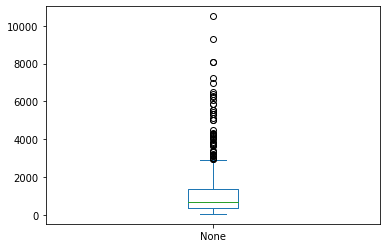

In [6]:
number_of_notes_per_song.plot.box()

In [7]:

note_duration = pd.Series(dtype="float64")
for song in data_dict.values():
    note_duration = pd.concat([note_duration, song['end'] - song['start']])
print("\nAbout note duration (in seconds):")
print(note_duration.describe())


About note duration (in seconds):
count    797367.000000
mean          0.415639
std           0.475598
min           0.002273
25%           0.168182
50%           0.250000
75%           0.500000
max          32.000000
dtype: float64


<AxesSubplot:>

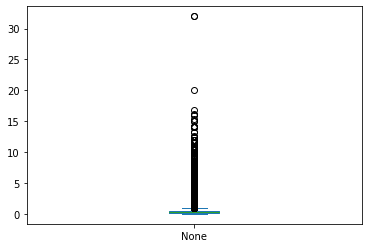

In [8]:
note_duration.plot.box()

In [9]:

pitch_stats = pd.Series(dtype="float64")
for song in data_dict.values():
    pitch_stats = pd.concat([pitch_stats, song['pitch']])
print("\nAbout note pitch:")
print(pitch_stats.describe())


About note pitch:
count    797367.000000
mean         63.200359
std          12.086736
min          17.000000
25%          55.000000
50%          63.000000
75%          72.000000
max         105.000000
dtype: float64


<AxesSubplot:>

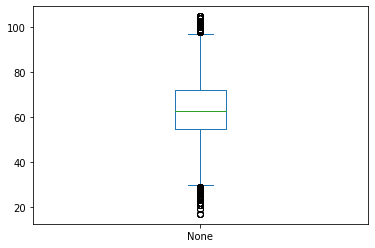

In [10]:
pitch_stats.plot.box()

### Pitch treatment

As seen in previous snippet, the pitch of the notes vary from 17 to 105 in value, which can be translated from 21.83 Hz to 3520 Hz.
In a regular piano, the note of 21.83Hz is not achievable. The piano notes only start from 27.50Hz, which is the note A0, in MIDI pitch value of 21.
Having this in mind we can remove all notes under the pitch value of 21.

The max pitch value of 105 (or A7, 3520Hz) is valid for piano, so we don't need to trim in the high-pitch side.

In [11]:
for song in data_dict.values():
    song.drop(song[song['pitch'] < 21].index, inplace=True)

min_pitch, max_pitch = np.inf , 0

for song in data_dict.values():
    min_pitch = min(min_pitch, song['pitch'].min())
    max_pitch = max(max_pitch, song['pitch'].max())

print(f'Pitch\nMin: {min_pitch}\tMax: {max_pitch}')
    

Pitch
Min: 21	Max: 105


After removing invalid pitch values, the values can be normalized between the min and max values.

In [12]:
for song in data_dict.values():
    song['pitch'] = (song['pitch'] - 21) / (105 - 21)

In [13]:
dict_key = list(data_dict.keys())[0]
print(f'{dict_key}\n{"-"*40}\n{data_dict[dict_key]}')

160_EIGHTMEASURE_EXERCISES_NO_1
----------------------------------------
         start        end     pitch
0     0.000000   0.136364  0.654762
3     0.000000   0.545455  0.464286
4     0.000000   0.545455  0.547619
1     0.136364   0.272727  0.690476
2     0.272727   0.409091  0.666667
..         ...        ...       ...
147  15.818182  15.954545  0.607143
148  15.954545  16.090909  0.654762
149  16.090909  16.227273  0.690476
150  16.227273  16.363636  0.750000
151  16.363636  16.636364  0.607143

[152 rows x 3 columns]


## Note duration

As some of the notes stay on for far more than most of the other notes, these can be trimmed to have a more uniform selection of notes.


About note duration (in seconds):
count    797128.000000
mean          0.413021
std           0.447361
min           0.002273
25%           0.168182
50%           0.250000
75%           0.500000
max           7.000000
dtype: float64


<AxesSubplot:>

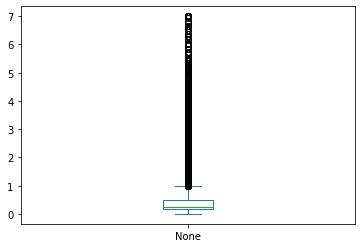

In [14]:
for song in data_dict.values():
    song.drop(song[(song['end'] - song['start']) > 7].index, inplace=True) ## arbitrarily chosen to 7s as max duration

note_duration = pd.Series(dtype="float64")
for song in data_dict.values():
    note_duration = pd.concat([note_duration, song['end'] - song['start']])
print("\nAbout note duration (in seconds):")
print(note_duration.describe())
note_duration.plot.box()

## Storing the data

Lastly, the data can be stored as a JSON file.

In [15]:
with open('.\\data\\treated_data.json', 'w+') as f:
    data_to_store = {}
    for song in data_dict:
        data_to_store.update({song: data_dict[song].to_json()})
    json.dump(data_to_store, f, indent=2)